In [72]:
import torch
import torch.nn as nn
import numpy as np
from functools import partial

from torch.optim.lr_scheduler import StepLR

from model import NN
from functions import gaussian_loss_function
from train import training_routine, testing_routine
from visuals import plot_transformed_grid_and_density, compute_gaussian_density, compute_uniform_circle_density

from matplotlib import pyplot as plt

In [73]:
torch.set_default_dtype(torch.float32)
torch.manual_seed(2)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
device

device(type='cuda', index=0)

In [320]:
angles = np.linspace(0, 2*np.pi, 20)
circle = np.stack((np.cos(angles), np.sin(angles)), axis=1)
amplitude = np.sin(5*angles)+2
star = circle*amplitude.reshape(-1,1)

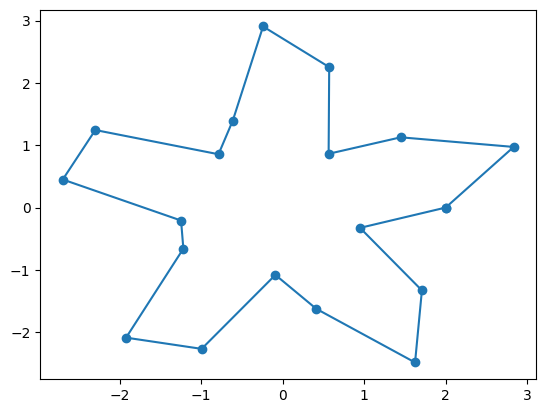

In [321]:
plt.plot(star[:,0], star[:,1], '-o')
#star = torch.tensor(star, device=device)
#star = torch.concatenate((torch.tensor([[0.,0.]], device=device, requires_grad = False), star))
#compute_volume(torch.tensor(circle))

In [371]:
# Isoperimetrisches Problem

def isoperimetric_loss(points):
    #diff = torch.diff(torch.concatenate((points, points[:1])), axis=0)
    diff = torch.diff(points, axis=0)
    distances = (torch.sum(diff**2, axis=1)**0.5 - 1)**2
    return torch.sum(distances)

def orthogonal_projection(v, grad):
    return grad - grad@v * v / torch.norm(v)**2


In [231]:
# functions to access gradient

def get_grad_vector(model):
    weights = []
    
    for coupling_layer in model.layers:
        for linear_layer in coupling_layer.t_net:
            weights.append(linear_layer.weight.grad)
            #weights.append(linear_layer.bias.grad)
        for linear_layer in coupling_layer.s_net:
            weights.append(linear_layer.weight.grad)
            #weights.append(linear_layer.bias.grad)

    vector = torch.concatenate([w.flatten() for w in weights])
    return vector

def get_shapes(model):
    shapes = []
    
    for coupling_layer in model.layers:
        for linear_layer in coupling_layer.t_net:
            shapes.append(linear_layer.weight.shape)
            #shapes.append(linear_layer.bias.shape)
        for linear_layer in coupling_layer.s_net:
            shapes.append(linear_layer.weight.shape)
            #shapes.append(linear_layer.bias.shape)

    return shapes 

def get_weights_from_vector(vector, shapes):
    lengths = [np.prod(s) for s in shapes]
    return [t.reshape(shapes[i]) for i,t in  enumerate(torch.split(vector, lengths))]

def assign_grad_weights(model, grad_weights):
    counter = 0
    
    for coupling_layer in model.layers:
        for linear_layer in coupling_layer.t_net:
            linear_layer.weight.grad = grad_weights[counter]
            counter += 1
            #linear_layer.bias.grad = grad_weights[counter]
            #counter += 1
        for linear_layer in coupling_layer.s_net:
            linear_layer.weight.grad = grad_weights[counter]
            counter += 1
            #linear_layer.bias.grad = grad_weights[counter]
            #counter += 1

In [233]:
# functions for volume computation

def compute_area_triangle(points):
    diff = torch.diff(torch.concatenate((points, points[:1])), axis=0)
    distances = torch.sum(diff**2, axis=1)**0.5
    s = torch.sum(distances) / 2
    return (s*torch.prod(s - distances))**0.5
    
points = torch.tensor([[1,2], [3,4], [5,100]])
print(compute_area_triangle(points))

def compute_volume(points, origin=torch.tensor([0,0], device=device, requires_grad=False)):
    sum_vol = 0
    for i in range(points.shape[0]-1):
        #print(compute_area_triangle(torch.concatenate([origin, points[i], points[i+1]]).reshape(3,2)))
        sum_vol += compute_area_triangle(torch.concatenate([origin, points[i], points[i+1]]).reshape(3,2))
    sum_vol +=compute_area_triangle(torch.concatenate([origin, points[-1], points[0]]).reshape(3,2))
    return sum_vol


def compute_area(points, origin=torch.tensor([0.,0.], device=device, requires_grad=False)):
    repeated = origin.repeat(points.shape[0], 1)
    stacked_points = torch.stack((repeated, points, torch.roll(points, -1, 0), repeated))
    t=torch.diff(stacked_points, axis=0)
    length=torch.sum(t**2, axis=2)**0.5
    s = torch.sum(length, axis=0)/2
    area_triangles=torch.prod(s-length,axis=0)**0.5 *s**0.5#, s, length, s-length
    area=torch.sum(area_triangles)
    return area


def compute_area2(points, device=device, requires_grad=False):
    coordinates = points - torch.mean(points, axis=0)
    normalized = torch.nn.functional.normalize(points, p=2, dim=1, eps=1e-12, out=None)
    norms = torch.norm(points, p=2., dim=1, keepdim=True)
    #print(norms)
    return torch.sum(torch.sin(torch.acos(torch.einsum ('ij, ij -> i', normalized[::2],normalized[1::2]))).reshape(-1,1) * norms[::2] * norms[1::2])


tensor(93.9996)


torch.Size([2000, 1])

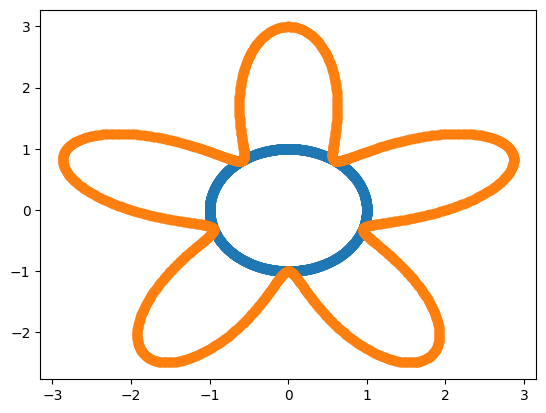

In [90]:
normalized = torch.nn.functional.normalize(star, p=2, dim=1, eps=1e-12, out=None)
normalized = normalized.detach().cpu().numpy()
plt.scatter(normalized[:,0], normalized[:,1])
norms = torch.norm(star, p=2., dim=1, keepdim=True)
np_star = normalized * norms.detach().cpu().numpy()

plt.scatter(np_star[:,0], np_star[:,1])
norms.shape

In [94]:
normalized = torch.nn.functional.normalize(star, p=2, dim=1, eps=1e-12, out=None)
star[::2], star[1::2]
print(torch.einsum ('ij, ij -> i', normalized[::2],normalized[1::2]).shape)
torch.sum(torch.sin(torch.acos(torch.einsum ('ij, ij -> i', normalized[::2],normalized[1::2]))).reshape(-1,1) * norms[::2] * norms[1::2])

torch.Size([1000])


tensor(14.1409, device='cuda:0')

In [103]:
# training routine

def training_routine_isoperimetric(model, train_data, optimizer):
    torch.autograd.set_detect_anomaly(True)
    model.train()
    #train_loss = 0

    # get volume grad
    optimizer.zero_grad(set_to_none=True)
    output = model(train_data)
    volume = compute_area2(output)
    volume.backward()
    #nn.utils.clip_grad_norm_(model.parameters(), max_norm=1, norm_type=1)
    volume_grad = get_grad_vector(model)
    #print(volume, volume_grad[:10])
    print('volume', volume)
    volume.detach()
    
    # get loss grad
    optimizer.zero_grad(set_to_none=True)
    output = model(train_data)
    loss = isoperimetric_loss(output)
    loss.backward()
    #nn.utils.clip_grad_norm_(model.parameters(), max_norm=1, norm_type=1)
    
    # project on subspace
    grad = get_grad_vector(model)
    #print(grad[:10])
    grad_projected = orthogonal_projection(volume_grad, grad)
    #print(grad_projected[:10])
    shapes = get_shapes(model)
    grad_weigths = get_weights_from_vector(grad_projected, shapes)
    
    # assign values
    assign_grad_weights(model, grad_weigths)

    # train step
    #nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1, norm_type=1)
    optimizer.step()
    loss = loss.detach()
    print('loss', loss)
    return volume_grad, grad 

In [20]:
# functions for error search

def get_weights_vector(model):
    with torch.no_grad():
        weights = []
        
        for coupling_layer in model.layers:
            for linear_layer in coupling_layer.t_net:
                weights.append(linear_layer.weight)
                #weights.append(linear_layer.bias)
            for linear_layer in coupling_layer.s_net:
                weights.append(linear_layer.weight)
                #weights.append(linear_layer.bias)
    
        vector = torch.concatenate([w.flatten() for w in weights])
        return vector

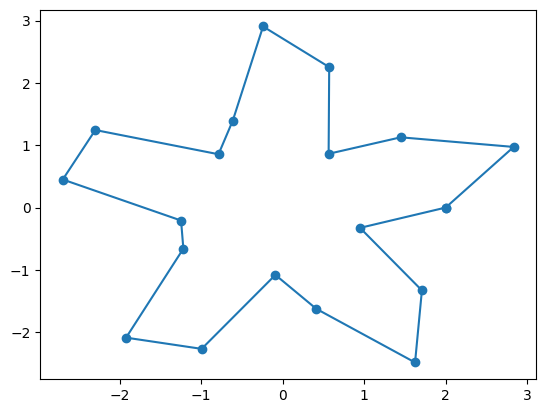

In [324]:
plt.plot(star[:,0], star[:,1], '-o')
star = torch.tensor(star, device=device, dtype=torch.float32)

In [226]:
model = NN(num_coupling_layers=12, split_size_x1=1, nn_size=(1, 10)).to(device)


In [227]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.8)
scheduler = StepLR(optimizer, step_size=1, gamma=0.99)

In [131]:
torch.autograd.set_detect_anomaly(False)

optimizer.zero_grad(set_to_none=True)
output = model(star[1:])
loss = isoperimetric_loss(output)
loss.backward()



In [132]:
shapes = get_shapes(model)
get_weights_from_vector(get_grad_vector(model), shapes)

[tensor([[-0.0004],
         [-0.0008],
         [ 0.0076],
         [ 0.1760],
         [ 0.0010],
         [-0.0079],
         [ 0.1586],
         [ 0.0540],
         [ 0.0065],
         [ 0.2334]], device='cuda:0'),
 tensor([[-0.0145, -0.1163, -0.0173, -0.0418, -0.0274, -0.0153, -0.0755, -0.4081,
          -0.0145, -0.4659],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000],
         [ 0.0005,  0.0000,  0.0006,  0.0000,  0.0010,  0.0005,  0.0000,  0.0000,
           0.0005,  0.0000],
         [ 0.0017,  0.0137,  0.0020,  0.0049,  0.0032,  0.0018,  0.0089,  0.0480,
           0.0017,  0.0548],
         [ 0.0021,  0.0000,  0.0025,  0.0000,  0.0039,  0.0022,  0.0000,  0.0000,
           0.0021,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000],
    

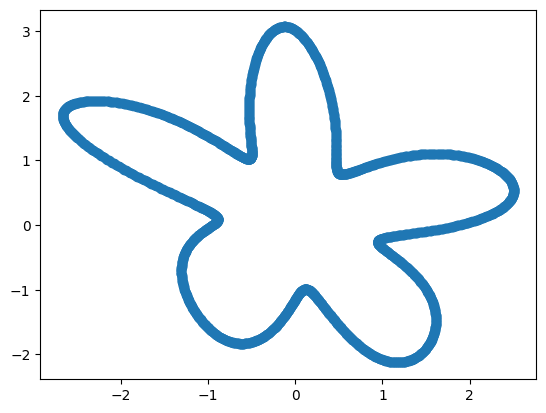

In [144]:
output = model(star)
initial_transformed_star = output.detach().cpu().numpy()
plt.plot(initial_transformed_star[:,0], initial_transformed_star[:,1], '-o')

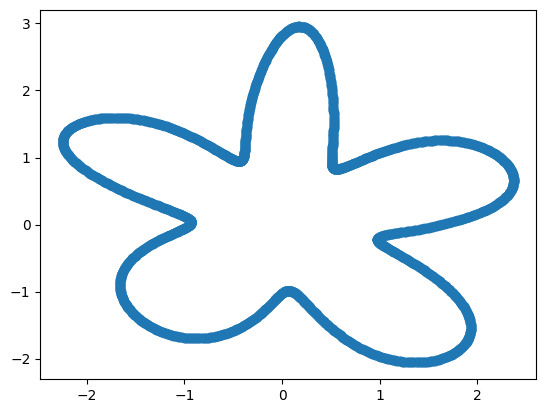

In [147]:
output = model(star)
initial_transformed_star = output.detach().cpu().numpy()
plt.plot(initial_transformed_star[:,0], initial_transformed_star[:,1], '-o')

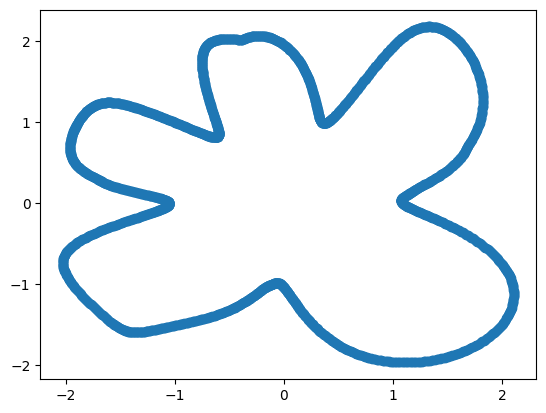

In [158]:
output = model(star)
initial_transformed_star = output.detach().cpu().numpy()
plt.plot(initial_transformed_star[:,0], initial_transformed_star[:,1], '-o')

In [153]:
%%time

# weights = []
# gradients = []

for _ in range(100):
    v,g = training_routine_isoperimetric(model, star, optimizer)
    if _ % 5 == 0:
        scheduler.step()
    weights.append(get_weights_vector(model))
    gradients.append(get_grad_vector(model))

volume tensor(11.0614, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(18.9538, device='cuda:0')
volume tensor(11.0631, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(18.9458, device='cuda:0')
volume tensor(11.0640, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(18.9378, device='cuda:0')
volume tensor(11.0609, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(18.9294, device='cuda:0')
volume tensor(11.0683, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(18.9207, device='cuda:0')
volume tensor(11.0747, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(18.9119, device='cuda:0')
volume tensor(11.0752, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(18.9028, device='cuda:0')
volume tensor(11.0739, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(18.8936, device='cuda:0')
volume tensor(11.0733, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(18.8837, device='cuda:0')
volume tensor(11.0791, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(18.873

D:\master-thesis\venv\Lib\site-packages\torch\autograd\__init__.py:266: UserWarning: Error detected in struct torch::autograd::CopySlices. Traceback of forward call that caused the error:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "D:\master-thesis\venv\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "D:\master-thesis\venv\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "D:\master-thesis\venv\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.start()
  File "D:\master-thesis\venv\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 638, in run_forever
    self._run_once()
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\a

RuntimeError: Function 'struct torch::autograd::CopySlices' returned nan values in its 0th output.

In [196]:
def compute_area2(points, device=device, requires_grad=False):
    #coordinates = points - torch.mean(points, axis=0)
    normalized = torch.nn.functional.normalize(points, p=2, dim=1, eps=1e-12, out=None)
    first, second = normalized[::2],normalized[1::2]
    norms = torch.norm(points, p=2., dim=1, keepdim=True)
    n_first, n_second = norms[::2],  norms[1::2]
    print(norms)
    print(torch.sin(torch.acos(torch.einsum ('ij, ij -> i', first, second ))))
    return torch.sum(torch.sin(torch.acos(torch.einsum ('ij, ij -> i', first, second )))* n_first.flatten() * n_second.flatten())


torch.autograd.set_detect_anomaly(False)
optimizer.zero_grad(set_to_none=True)
output = model(star)
volume = compute_area2(output)
print(volume)
volume.backward()


tensor([[1.8242],
        [1.8354],
        [1.8467],
        ...,
        [1.8102],
        [1.8172],
        [1.8242]], device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor([0.0050, 0.0050, 0.0051, 0.0051, 0.0052, 0.0052, 0.0053, 0.0053, 0.0054,
        0.0054, 0.0054, 0.0054, 0.0055, 0.0055, 0.0055, 0.0056, 0.0056, 0.0056,
        0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0055, 0.0055,
        0.0055, 0.0055, 0.0054, 0.0054, 0.0054, 0.0053, 0.0053, 0.0052, 0.0051,
        0.0051, 0.0050, 0.0049, 0.0049, 0.0048, 0.0047, 0.0046, 0.0045, 0.0045,
        0.0044, 0.0043, 0.0042, 0.0041, 0.0040, 0.0039, 0.0038, 0.0038, 0.0037,
        0.0036, 0.0035, 0.0034, 0.0033, 0.0032, 0.0031, 0.0030, 0.0029, 0.0028,
        0.0027, 0.0026, 0.0025, 0.0024, 0.0024, 0.0023, 0.0022, 0.0021, 0.0020,
        0.0020, 0.0019, 0.0018, 0.0017, 0.0017, 0.0016, 0.0015, 0.0014, 0.0013,
        0.0014, 0.0013, 0.0012, 0.0011, 0.0011, 0.0010, 0.0011, 0.0009, 0.0010,
        0.0010, 0.0007, 

In [197]:
shapes = get_shapes(model)
get_weights_from_vector(get_grad_vector(model), shapes)

[tensor([[ 0.0121],
         [    nan],
         [-0.0021],
         [    nan],
         [-0.0254],
         [-0.0181],
         [    nan],
         [-0.0040],
         [-0.0611],
         [ 0.0060]], device='cuda:0'),
 tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000],
         [-0.0081,  0.0000, -0.0105,  0.0000, -0.0099, -0.0058,  0.0000, -0.0047,
          -0.0043, -0.0096],
         [    nan,     nan,     nan,     nan,     nan,     nan,     nan,     nan,
              nan,     nan],
         [    nan,     nan,     nan,     nan,     nan,     nan,     nan,     nan,
              nan,     nan],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000],
         [    nan,     nan,     nan,     nan,     nan,     nan,     nan,     nan,
              nan,     nan],
         [    nan,     nan,     nan,     nan,     nan,     nan,     nan,     nan,
              nan,     nan],
    

In [157]:
get_weights_from_vector(gradients[-1], shapes)

[tensor([[-0.0064],
         [ 0.0005],
         [ 0.0011],
         [ 0.0008],
         [ 0.0128],
         [ 0.0092],
         [ 0.0004],
         [ 0.0020],
         [ 0.0312],
         [-0.0033]], device='cuda:0'),
 tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 4.4663e-03,  0.0000e+00,  5.8179e-03,  0.0000e+00,  5.4892e-03,
           3.2249e-03,  0.0000e+00,  2.6041e-03,  2.3567e-03,  5.2788e-03],
         [-4.5456e-03, -2.1613e-05, -5.9212e-03, -2.8579e-04, -5.5866e-03,
          -3.2821e-03, -1.5870e-04, -2.6504e-03, -2.3985e-03, -5.3725e-03],
         [ 3.7685e-02,  1.7916e-04,  4.9089e-02,  2.3693e-03,  4.6315e-02,
           2.7210e-02,  1.3156e-03,  2.1973e-02,  1.9885e-02,  4.4540e-02],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 4.8356e-03,  2.

In [187]:
get_weights_from_vector(weights[-2], shapes)

[tensor([[-0.5548],
         [ 0.0650],
         [-0.7227],
         [ 0.8597],
         [-0.6819],
         [-0.4006],
         [ 0.4773],
         [-0.3235],
         [-0.2928],
         [-0.6558]], device='cuda:0'),
 tensor([[ 0.0215,  0.1798, -0.2779, -0.0964,  0.1665, -0.1752,  0.1394,  0.1287,
          -0.0844, -0.0099],
         [ 0.3147,  0.1407, -0.0823, -0.1538,  0.2270,  0.0760,  0.1417,  0.0346,
           0.2881,  0.3080],
         [ 0.0616,  0.0588,  0.0807,  0.1650,  0.1790, -0.1459,  0.1248, -0.0837,
          -0.1537, -0.1046],
         [-0.0424,  0.1356,  0.1147,  0.2495,  0.1182, -0.1875,  0.2965,  0.2099,
          -0.1134, -0.1415],
         [ 0.1103, -0.1041,  0.0741, -0.1205, -0.1739, -0.2008, -0.2801, -0.1787,
           0.1490,  0.0790],
         [-0.0401, -0.0791,  0.2065,  0.2524, -0.0468, -0.1732, -0.0171, -0.0950,
          -0.2605,  0.1998],
         [-0.2735, -0.0380, -0.0034,  0.0204,  0.2392,  0.3008,  0.0373, -0.0212,
          -0.2078, -0.1823],
    

In [188]:
get_weights_from_vector(weights[-1], shapes)

[tensor([[-0.5548],
         [ 0.0650],
         [-0.7227],
         [ 0.8597],
         [-0.6819],
         [-0.4006],
         [ 0.4773],
         [-0.3235],
         [-0.2929],
         [-0.6557]], device='cuda:0'),
 tensor([[ 0.0215,  0.1798, -0.2779, -0.0964,  0.1665, -0.1752,  0.1394,  0.1287,
          -0.0844, -0.0099],
         [ 0.3147,  0.1407, -0.0823, -0.1538,  0.2270,  0.0760,  0.1417,  0.0346,
           0.2880,  0.3079],
         [ 0.0617,  0.0588,  0.0807,  0.1650,  0.1790, -0.1459,  0.1248, -0.0837,
          -0.1537, -0.1046],
         [-0.0425,  0.1356,  0.1145,  0.2495,  0.1180, -0.1876,  0.2965,  0.2098,
          -0.1134, -0.1417],
         [ 0.1103, -0.1041,  0.0741, -0.1205, -0.1739, -0.2008, -0.2801, -0.1787,
           0.1490,  0.0790],
         [-0.0401, -0.0791,  0.2064,  0.2524, -0.0468, -0.1733, -0.0171, -0.0950,
          -0.2605,  0.1998],
         [-0.2735, -0.0380, -0.0034,  0.0204,  0.2392,  0.3008,  0.0374, -0.0212,
          -0.2078, -0.1823],
    

## NaN Gradients können mit größeren Werten behoben werden

In [204]:
torch.autograd.set_detect_anomaly(False)
optimizer.zero_grad(set_to_none=True)
output = model(star)*5
volume = compute_area2(output)
print(volume)
volume.backward()

tensor([[9.1208],
        [9.1772],
        [9.2334],
        ...,
        [9.0508],
        [9.0862],
        [9.1208]], device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor([0.0049, 0.0050, 0.0051, 0.0051, 0.0052, 0.0052, 0.0053, 0.0053, 0.0053,
        0.0054, 0.0054, 0.0055, 0.0055, 0.0055, 0.0055, 0.0056, 0.0056, 0.0056,
        0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0055, 0.0055,
        0.0055, 0.0055, 0.0054, 0.0054, 0.0053, 0.0053, 0.0052, 0.0052, 0.0051,
        0.0051, 0.0050, 0.0049, 0.0049, 0.0048, 0.0047, 0.0046, 0.0046, 0.0045,
        0.0044, 0.0043, 0.0042, 0.0041, 0.0040, 0.0039, 0.0038, 0.0038, 0.0037,
        0.0036, 0.0034, 0.0033, 0.0033, 0.0032, 0.0031, 0.0030, 0.0029, 0.0028,
        0.0027, 0.0026, 0.0026, 0.0024, 0.0023, 0.0023, 0.0022, 0.0022, 0.0020,
        0.0020, 0.0019, 0.0018, 0.0017, 0.0017, 0.0016, 0.0015, 0.0015, 0.0014,
        0.0013, 0.0013, 0.0012, 0.0011, 0.0011, 0.0010, 0.0010, 0.0010, 0.0009,
        0.0008, 0.0008, 

In [205]:
shapes = get_shapes(model)
get_weights_from_vector(get_grad_vector(model), shapes)

[tensor([[ 0.3011],
         [-0.5046],
         [-0.0535],
         [-0.7921],
         [-0.6319],
         [-0.4504],
         [-0.4679],
         [-0.0987],
         [-1.5220],
         [ 0.1501]], device='cuda:0'),
 tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000],
         [-0.2013,  0.0000, -0.2622,  0.0000, -0.2474, -0.1454,  0.0000, -0.1174,
          -0.1063, -0.2379],
         [ 0.2212,  0.0228,  0.2882,  0.3018,  0.2719,  0.1598,  0.1676,  0.1290,
           0.1168,  0.2615],
         [-1.8289, -0.1886, -2.3824, -2.4949, -2.2480, -1.3207, -1.3853, -1.0664,
          -0.9654, -2.1616],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000],
         [-0.2333, -0.0241, -0.3039, -0.3182, -0.2867, -0.1685, -0.1767, -0.1360,
          -0.1231, -0.2757],
         [ 0.0000,  0.3446,  0.0000,  4.5573,  0.0000,  0.0000,  2.5305,  0.0000,
           0.0000,  0.0000],
    

In [206]:
def compute_area2(points, device=device, requires_grad=False):
    #coordinates = points - torch.mean(points, axis=0)
    normalized = torch.nn.functional.normalize(points, p=2, dim=1, eps=1e-12, out=None)
    first, second = normalized[::2],normalized[1::2]
    norms = torch.norm(points, p=2., dim=1, keepdim=True)
    n_first, n_second = norms[::2],  norms[1::2]
    return torch.sum(torch.sin(torch.acos(torch.einsum ('ij, ij -> i', first, second )))* n_first.flatten() * n_second.flatten())


In [225]:
%%time

# training routine

def training_routine_isoperimetric(model, train_data, optimizer):
    torch.autograd.set_detect_anomaly(False)
    model.train()
    #train_loss = 0

    # get volume grad
    optimizer.zero_grad(set_to_none=True)
    output = model(train_data)
    volume = compute_area2(output)
    volume.backward()
    #nn.utils.clip_grad_norm_(model.parameters(), max_norm=1, norm_type=1)
    volume_grad = get_grad_vector(model)
    #volume_grad = torch.nan_to_num(volume_grad)
    #print(volume, volume_grad[:10])
    print('volume', volume)
    volume.detach()
    
    # get loss grad
    optimizer.zero_grad(set_to_none=True)
    output = model(train_data)
    loss = isoperimetric_loss(output)
    loss.backward()
    #nn.utils.clip_grad_norm_(model.parameters(), max_norm=1, norm_type=1)
    
    # project on subspace
    grad = get_grad_vector(model)
    #print(grad[:10])
    grad_projected = orthogonal_projection(volume_grad, grad)
    #print(grad_projected[:10])
    shapes = get_shapes(model)
    grad_weigths = get_weights_from_vector(grad_projected, shapes)
    
    # assign values
    assign_grad_weights(model, grad_weigths)

    # train step
    #nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1, norm_type=1)
    optimizer.step()
    loss = loss.detach()
    print('loss', loss)
    return volume_grad, grad 


# weights = []
# gradients = []

for _ in range(100):
    v,g = training_routine_isoperimetric(model, star, optimizer)
    if _ % 5 == 0:
        scheduler.step()
    weights.append(get_weights_vector(model))
    gradients.append(get_grad_vector(model))

volume tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(7.7032, device='cuda:0')
volume tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(nan, device='cuda:0')
volume tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(nan, device='cuda:0')
volume tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(nan, device='cuda:0')
volume tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(nan, device='cuda:0')
volume tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(nan, device='cuda:0')
volume tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(nan, device='cuda:0')
volume tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(nan, device='cuda:0')
volume tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(nan, device='cuda:0')
volume tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(nan, device='cuda:0')
volume tensor(nan, device='cuda:0', grad_fn=<SumBackward0

KeyboardInterrupt: 

In [222]:
torch.autograd.set_detect_anomaly(False)
optimizer.zero_grad(set_to_none=True)
output = model(star)
volume = compute_area2(output)
print(volume)
volume.backward()

tensor(11.1147, device='cuda:0', grad_fn=<SumBackward0>)


In [221]:
shapes = get_shapes(model)
get_weights_from_vector(get_grad_vector(model), shapes)

[tensor([[ 1.2210e-04],
         [        nan],
         [-2.7221e-05],
         [        nan],
         [-3.2589e-04],
         [-2.2376e-04],
         [        nan],
         [-5.3155e-05],
         [-7.4923e-04],
         [ 4.7084e-05]], device='cuda:0'),
 tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-6.5357e-05,  0.0000e+00, -8.5158e-05,  0.0000e+00, -8.0372e-05,
          -4.7223e-05,  0.0000e+00, -3.8121e-05, -3.4565e-05, -7.7256e-05],
         [        nan,         nan,         nan,         nan,         nan,
                  nan,         nan,         nan,         nan,         nan],
         [        nan,         nan,         nan,         nan,         nan,
                  nan,         nan,         nan,         nan,         nan],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, 

In [213]:
optimizer.zero_grad(set_to_none=True)
output = model(star)
loss = isoperimetric_loss(output)
loss.backward()

In [214]:
shapes = get_shapes(model)
get_weights_from_vector(get_grad_vector(model), shapes)

[tensor([[ 0.0082],
         [-0.0254],
         [-0.0015],
         [-0.0397],
         [-0.0183],
         [-0.0129],
         [-0.0235],
         [-0.0029],
         [-0.0435],
         [ 0.0039]], device='cuda:0'),
 tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000],
         [-0.0053,  0.0000, -0.0069,  0.0000, -0.0065, -0.0038,  0.0000, -0.0031,
          -0.0028, -0.0062],
         [ 0.0063,  0.0011,  0.0082,  0.0152,  0.0078,  0.0046,  0.0084,  0.0037,
           0.0033,  0.0075],
         [-0.0520, -0.0095, -0.0677, -0.1252, -0.0639, -0.0376, -0.0695, -0.0303,
          -0.0275, -0.0615],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000],
         [-0.0066, -0.0012, -0.0086, -0.0159, -0.0081, -0.0048, -0.0088, -0.0038,
          -0.0035, -0.0078],
         [ 0.0000,  0.0173,  0.0000,  0.2288,  0.0000,  0.0000,  0.1271,  0.0000,
           0.0000,  0.0000],
    

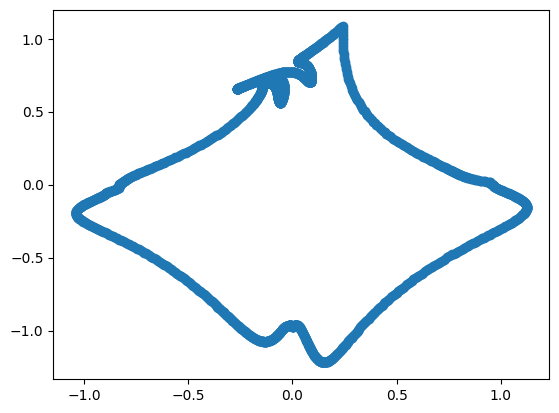

In [224]:
output = model(star)
initial_transformed_star = output.detach().cpu().numpy()
plt.plot(initial_transformed_star[:,0], initial_transformed_star[:,1], '-o')

tensor([-0.5552,  0.0640, -0.7228,  ..., -0.2711,  0.1859,  0.0326],
       device='cuda:0')
tensor([-0.5548,  0.0650, -0.7227,  ..., -0.2826,  0.1811,  0.0326],
       device='cuda:0')


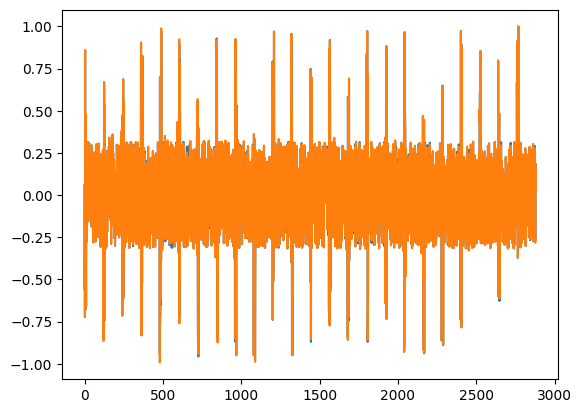

In [208]:
for w in ([weights[0], weights[-1]]):
    plt.plot(w.detach().cpu().numpy())
    print(w)

tensor([ 0.0099,  0.0177, -0.0030,  ...,  0.3459, -0.0628,  0.0000],
       device='cuda:0')
tensor([-0.0061,  0.0006,  0.0011,  ...,  0.0145,  0.0036,  0.0000],
       device='cuda:0')


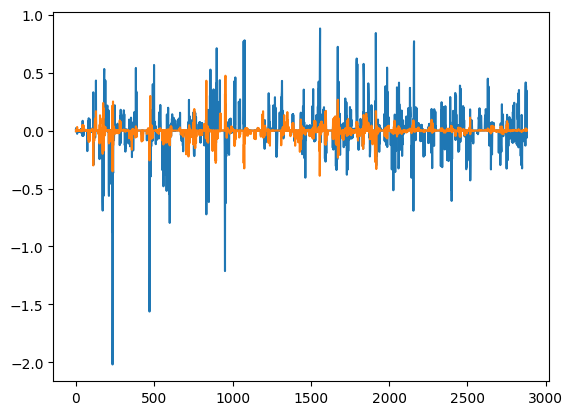

In [209]:
for w in ([gradients[0], gradients[-1]]):
    plt.plot(w.detach().cpu().numpy())
    print(w)

In [341]:
model = NN(num_coupling_layers=12, split_size_x1=1, nn_size=(1, 10)).to(device)


In [342]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.8)
scheduler = StepLR(optimizer, step_size=1, gamma=0.99)

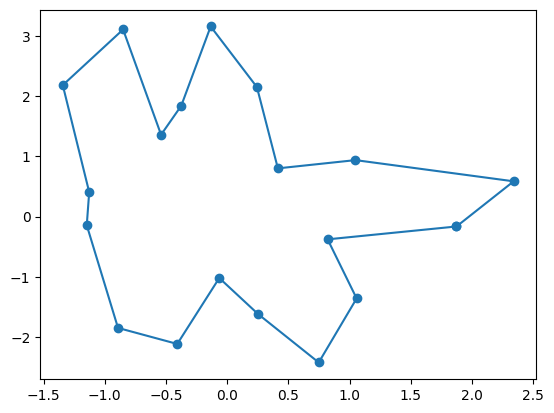

In [343]:
output = model(star)
initial_transformed_star = output.detach().cpu().numpy()
plt.plot(initial_transformed_star[:,0], initial_transformed_star[:,1], '-o')

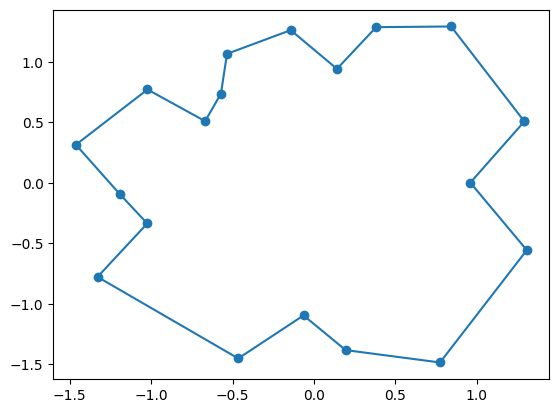

In [346]:
output = model(star)
initial_transformed_star = output.detach().cpu().numpy()
plt.plot(initial_transformed_star[:,0], initial_transformed_star[:,1], '-o')

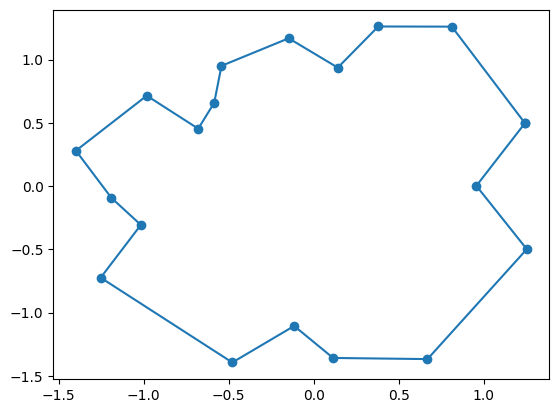

In [348]:
output = model(star)
initial_transformed_star = output.detach().cpu().numpy()
plt.plot(initial_transformed_star[:,0], initial_transformed_star[:,1], '-o')

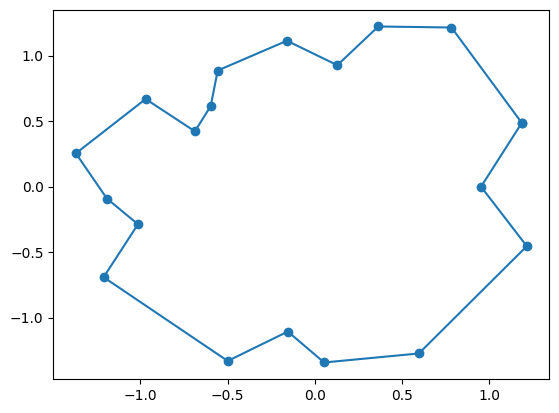

In [350]:
output = model(star)
initial_transformed_star = output.detach().cpu().numpy()
plt.plot(initial_transformed_star[:,0], initial_transformed_star[:,1], '-o')

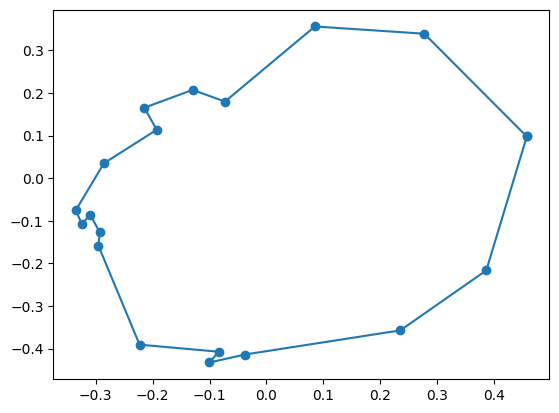

In [353]:
output = model(star)
initial_transformed_star = output.detach().cpu().numpy()
plt.plot(initial_transformed_star[:,0], initial_transformed_star[:,1], '-o')

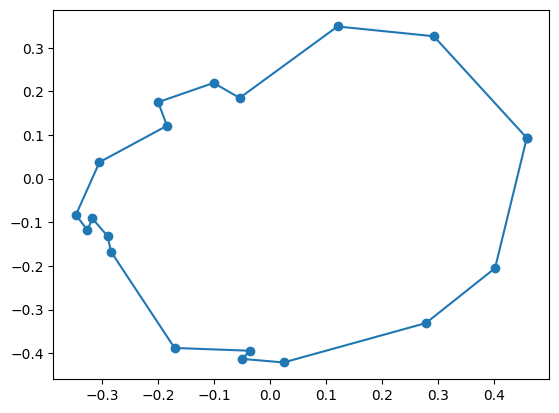

In [355]:
output = model(star)
initial_transformed_star = output.detach().cpu().numpy()
plt.plot(initial_transformed_star[:,0], initial_transformed_star[:,1], '-o')

In [280]:
scheduler.get_last_lr()

[0.0001]

In [356]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.8)
scheduler = StepLR(optimizer, step_size=1, gamma=0.99)

In [357]:
%%time
torch.autograd.set_detect_anomaly(True)
weights = []
gradients = []

for _ in range(100):
    v,g = training_routine_isoperimetric(model, star, optimizer)
    if _ % 100 == 0:
        scheduler.step()
    weights.append(get_weights_vector(model))
    gradients.append(get_grad_vector(model))

volume tensor(0.5759, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(0.5082, device='cuda:0')
volume tensor(0.5759, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(0.5077, device='cuda:0')
volume tensor(0.5759, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(0.5069, device='cuda:0')
volume tensor(0.5759, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(0.5058, device='cuda:0')
volume tensor(0.5759, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(0.5048, device='cuda:0')
volume tensor(0.5752, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(0.5476, device='cuda:0')
volume tensor(0.4104, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(1.9727, device='cuda:0')
volume tensor(0.2624, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(1.2279, device='cuda:0')
volume tensor(0.2826, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(1.3202, device='cuda:0')
volume tensor(0.5518, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(1.3275, device='cuda:0')


In [363]:
model = NN(num_coupling_layers=12, split_size_x1=1, nn_size=(1, 10)).to(device)


In [367]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.003, momentum=0.8)
scheduler = StepLR(optimizer, step_size=1, gamma=0.99)

In [370]:
%%time
torch.autograd.set_detect_anomaly(True)
weights = []
gradients = []

for _ in range(100):
    v,g = training_routine_isoperimetric(model, star, optimizer)
    if _ % 100 == 0:
        scheduler.step()
    weights.append(get_weights_vector(model))
    gradients.append(get_grad_vector(model))

volume tensor(8.5684, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(5.3057, device='cuda:0')
volume tensor(8.6040, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(5.1568, device='cuda:0')
volume tensor(8.6324, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(4.9998, device='cuda:0')
volume tensor(8.6493, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(4.8324, device='cuda:0')
volume tensor(8.6530, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(4.6539, device='cuda:0')
volume tensor(8.6429, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(4.4645, device='cuda:0')
volume tensor(8.6555, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(4.2748, device='cuda:0')
volume tensor(8.6435, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(4.1053, device='cuda:0')
volume tensor(8.6905, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(3.9757, device='cuda:0')
volume tensor(8.8127, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(3.9131, device='cuda:0')


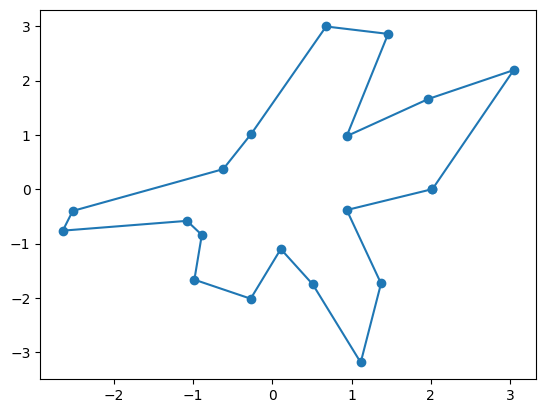

In [364]:
output = model(star)
initial_transformed_star = output.detach().cpu().numpy()
plt.plot(initial_transformed_star[:,0], initial_transformed_star[:,1], '-o')

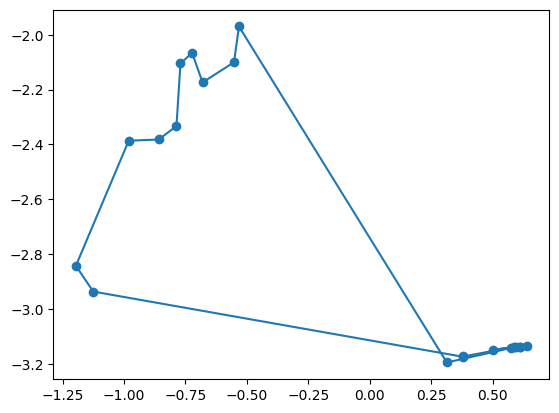

In [369]:
output = model(star)
initial_transformed_star = output.detach().cpu().numpy()
plt.plot(initial_transformed_star[:,0], initial_transformed_star[:,1], '-o')

In [426]:
# training routine

def training_routine_isoperimetric(model, train_data, optimizer):
    torch.autograd.set_detect_anomaly(True)
    model.train()
    #train_loss = 0

    # # get volume grad
    # optimizer.zero_grad(set_to_none=True)
    # output = model(train_data)
    # volume = compute_area2(output)
    # volume.backward()
    # #nn.utils.clip_grad_norm_(model.parameters(), max_norm=1, norm_type=1)
    # volume_grad = get_grad_vector(model)
    # #print(volume, volume_grad[:10])
    # print('volume', volume)
    # volume.detach()
    
    # get loss grad
    optimizer.zero_grad(set_to_none=True)
    output = model(train_data)
    loss = isoperimetric_loss(output)
    volume = -compute_area2(output)
    weighted_loss = 1*loss + 0.2*volume
    weighted_loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1, norm_type=1)

    
    
    # # project on subspace
    # grad = get_grad_vector(model)
    # #print(grad[:10])
    # grad_projected = orthogonal_projection(volume_grad, grad)
    # #print(grad_projected[:10])
    # shapes = get_shapes(model)
    # grad_weigths = get_weights_from_vector(grad_projected, shapes)
    
    # # assign values
    # assign_grad_weights(model, grad_weigths)

    # train step
    #nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1, norm_type=1)
    optimizer.step()
    loss = loss.detach()
    volume = volume.detach()
    print('loss', loss)
    print('volume', volume)
    #return volume_grad, grad 

In [406]:
model = NN(num_coupling_layers=12, split_size_x1=1, nn_size=(1, 10)).to(device)


In [424]:
optimizer = torch.optim.SGD(model.parameters(), lr=1, momentum=0.8)
scheduler = StepLR(optimizer, step_size=1, gamma=0.99)

In [425]:
%%time
torch.autograd.set_detect_anomaly(True)
weights = []
gradients = []

for _ in range(100):
    training_routine_isoperimetric(model, star, optimizer)
    if _ % 100 == 0:
        scheduler.step()
    weights.append(get_weights_vector(model))
    gradients.append(get_grad_vector(model))

loss tensor(0.2646, device='cuda:0')
loss tensor(0.1826, device='cuda:0')
loss tensor(1.1199, device='cuda:0')
loss tensor(1.2929, device='cuda:0')
loss tensor(0.5010, device='cuda:0')
loss tensor(1.2779, device='cuda:0')
loss tensor(0.4181, device='cuda:0')
loss tensor(0.3329, device='cuda:0')
loss tensor(0.7849, device='cuda:0')
loss tensor(0.7512, device='cuda:0')
loss tensor(0.4443, device='cuda:0')
loss tensor(0.8054, device='cuda:0')
loss tensor(0.2906, device='cuda:0')
loss tensor(0.3616, device='cuda:0')
loss tensor(1.0387, device='cuda:0')
loss tensor(0.3701, device='cuda:0')
loss tensor(0.4980, device='cuda:0')
loss tensor(0.4888, device='cuda:0')
loss tensor(0.6545, device='cuda:0')
loss tensor(0.5134, device='cuda:0')
loss tensor(0.3647, device='cuda:0')
loss tensor(0.8252, device='cuda:0')
loss tensor(0.6116, device='cuda:0')
loss tensor(0.4952, device='cuda:0')
loss tensor(1.4273, device='cuda:0')
loss tensor(1.1430, device='cuda:0')
loss tensor(0.3733, device='cuda:0')
l

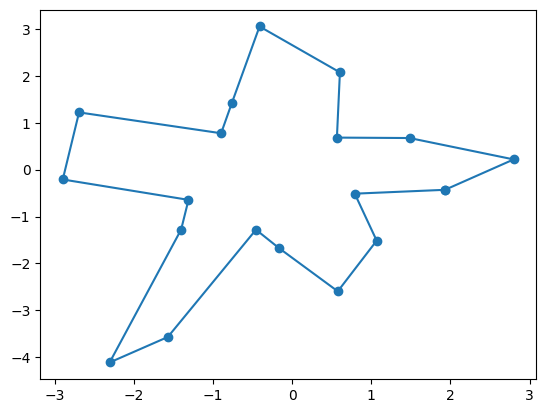

In [408]:
output = model(star)
initial_transformed_star = output.detach().cpu().numpy()
plt.plot(initial_transformed_star[:,0], initial_transformed_star[:,1], '-o')

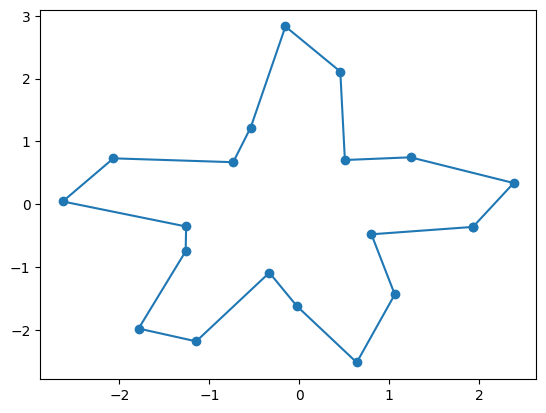

In [410]:
output = model(star)
initial_transformed_star = output.detach().cpu().numpy()
plt.plot(initial_transformed_star[:,0], initial_transformed_star[:,1], '-o')

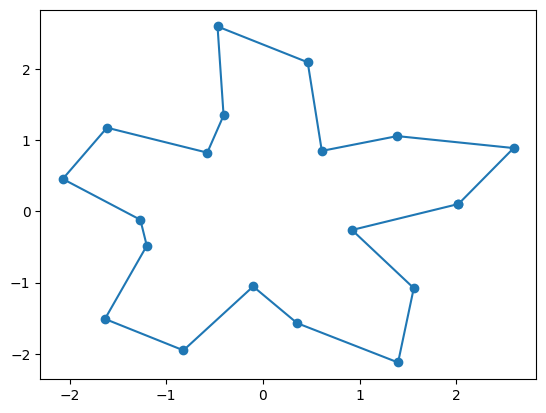

In [413]:
output = model(star)
initial_transformed_star = output.detach().cpu().numpy()
plt.plot(initial_transformed_star[:,0], initial_transformed_star[:,1], '-o')

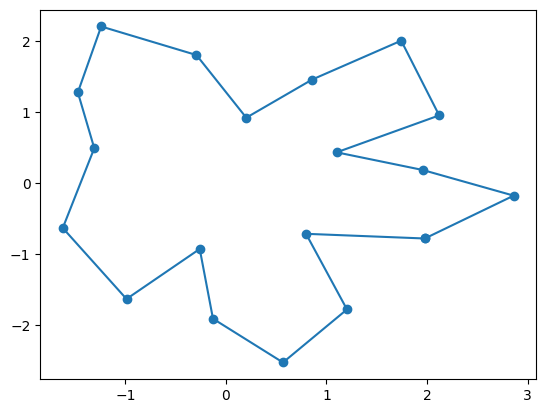

In [416]:
output = model(star)
initial_transformed_star = output.detach().cpu().numpy()
plt.plot(initial_transformed_star[:,0], initial_transformed_star[:,1], '-o')

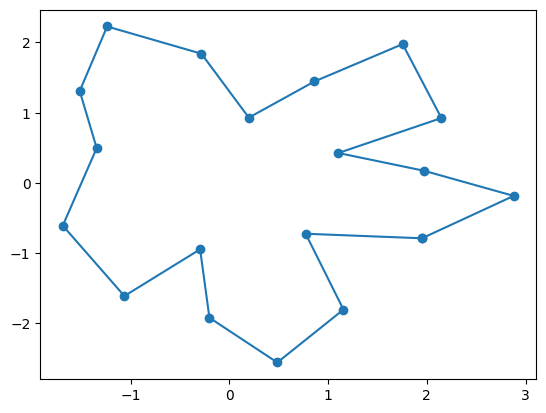

In [419]:
output = model(star)
initial_transformed_star = output.detach().cpu().numpy()
plt.plot(initial_transformed_star[:,0], initial_transformed_star[:,1], '-o')

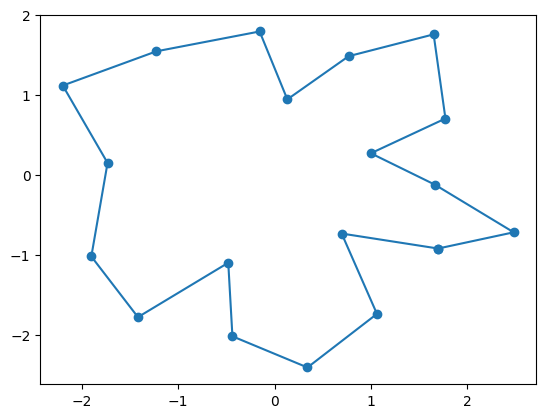

In [422]:
output = model(star)
initial_transformed_star = output.detach().cpu().numpy()
plt.plot(initial_transformed_star[:,0], initial_transformed_star[:,1], '-o')

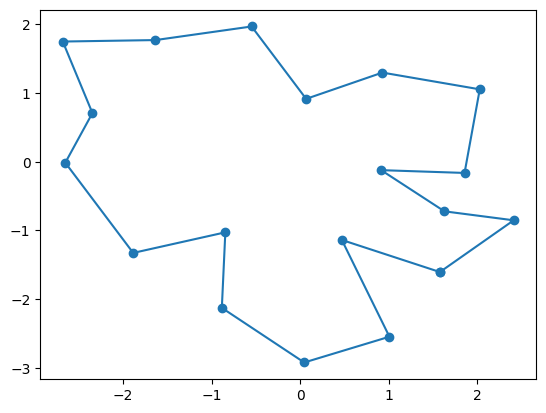

In [427]:
output = model(star)
initial_transformed_star = output.detach().cpu().numpy()
plt.plot(initial_transformed_star[:,0], initial_transformed_star[:,1], '-o')

In [ ]:
# abwechselnd, volume und perimeter trainieren